<a href="https://colab.research.google.com/github/vendyliang/MachineLearningProjects/blob/master/Telecommunication_User_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Telecommunication User Churn Prediction**

In this project, we use supervised learning models to identify customers who are likely to stop using service in the future. Furthermore, we will analyze top factors that influence user retention.

## Contents


* Part 1: Data Exploration
* Part 2: Feature Preprocessing
* Part 3: Model Training and Results Evaluation
* Part 4: Feature Selection

# Part 0: Setup Google Drive Environment

In [0]:
#install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1wvKi-E6GJnRqAkYMpVPaRc0L0XgY0Wkq' # the id of file we want to access
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) 
file.GetContentFile('churn.csv') #file name 

# Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [0]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

churn_df = pd.read_csv('churn.csv')

In [150]:
churn_df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [151]:
print ("Num of rows: " + str(churn_df.shape[0])) # row count
print ("Num of columns: " + str(churn_df.shape[1])) # col count

Num of rows: 5000
Num of columns: 21


In [0]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
state                            5000 non-null object
account_length                   5000 non-null int64
area_code                        5000 non-null int64
phone_number                     5000 non-null object
intl_plan                        5000 non-null object
voice_mail_plan                  5000 non-null object
number_vmail_messages            5000 non-null int64
total_day_minutes                5000 non-null float64
total_day_calls                  5000 non-null int64
total_day_charge                 5000 non-null float64
total_eve_minutes                5000 non-null float64
total_eve_calls                  5000 non-null int64
total_eve_charge                 5000 non-null float64
total_night_minutes              5000 non-null float64
total_night_calls                5000 non-null int64
total_night_charge               5000 non-null float64
total_intl_minutes           

### Part 1.2: Data cleaning

There are 5 columns that are categorical features: state, phone_number, intl_plan, voice_mail_plan, and churned columns.

Remove Extra Whitespace for 3 columns: intl_plan, voice_mail_plan, and churned

In [213]:
churn_df['voice_mail_plan'][0]

' yes'

In [214]:
churn_df['churned'][0]

' False.'

In [0]:
# remove the heading and trailing whitespaces
churn_df['voice_mail_plan'] = churn_df['voice_mail_plan'].apply(lambda x: x.strip())
churn_df['intl_plan'] = churn_df['intl_plan'].apply(lambda x: x.strip())
churn_df['churned'] = churn_df['churned'].apply(lambda x: x.strip())

In [216]:
# check the categorical feature after manipulation
churn_df['voice_mail_plan'][0]

'yes'

Remove the dot following 'False' and 'True'

In [217]:
churn_df['churned'][0]

'False.'

In [0]:
# remove the dot
churn_df['churned'].replace('False.', 'False', inplace = True)
churn_df['churned'].replace('True.', 'True', inplace = True)

In [219]:
# check the categorical feature after manipulation
churn_df['churned']

0       False
1       False
2       False
3       False
4       False
        ...  
4995    False
4996     True
4997    False
4998    False
4999    False
Name: churned, Length: 5000, dtype: object

There is no duplicated or missing values in this data set

In [159]:
#check duplication
if len(churn_df['phone_number'][churn_df['phone_number'].duplicated()]) == 0:
  print('There is no duplicated entry (phone_number based).')

There is no duplicated entry (phone_number based).


In [160]:
#check missing value
idx_col_nan = pd.isnull(churn_df).any(axis=0)# return bool value
print(idx_col_nan)

state                            False
account_length                   False
area_code                        False
phone_number                     False
intl_plan                        False
voice_mail_plan                  False
number_vmail_messages            False
total_day_minutes                False
total_day_calls                  False
total_day_charge                 False
total_eve_minutes                False
total_eve_calls                  False
total_eve_charge                 False
total_night_minutes              False
total_night_calls                False
total_night_charge               False
total_intl_minutes               False
total_intl_calls                 False
total_intl_charge                False
number_customer_service_calls    False
churned                          False
dtype: bool


### Part 1.3:  Understand the features

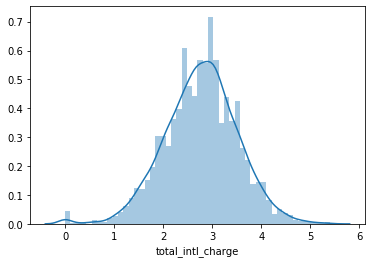

In [161]:
# check the feature distribution
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(churn_df['total_intl_charge'])

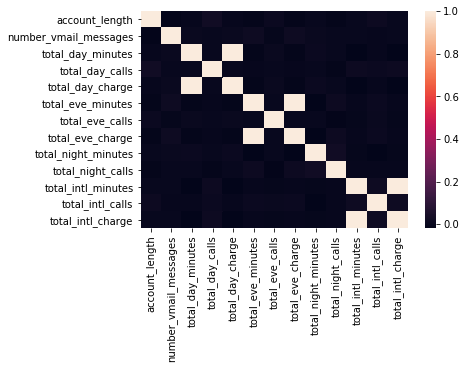

In [163]:
# correlations between all the features
corr = churn_df[["account_length", "number_vmail_messages", "total_day_minutes",
                    "total_day_calls", "total_day_charge", "total_eve_minutes",
                    "total_eve_calls", "total_eve_charge", "total_night_minutes",
                    "total_night_calls", "total_intl_minutes", "total_intl_calls",
                    "total_intl_charge"]].corr()

# show heapmap of correlations
sns.heatmap(corr)

In [164]:
# check the actual values of correlations
corr

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,total_intl_charge
account_length,1.000000,-0.014575,-0.001017,0.028240,-0.001019,-0.009591,0.009143,-0.009587,0.000668,-0.007825,0.001291,0.014277,0.001292
number_vmail_messages,-0.014575,1.000000,0.005381,0.000883,0.005377,0.019490,-0.003954,0.019496,0.005541,0.002676,0.002463,0.000124,0.002505
total_day_minutes,-0.001017,0.005381,1.000000,0.001935,1.000000,-0.010750,0.008128,-0.010760,0.011799,0.004236,-0.019486,-0.001303,-0.019415
total_day_calls,0.028240,0.000883,0.001935,1.000000,0.001936,-0.000699,0.003754,-0.000695,0.002804,-0.008308,0.013097,0.010893,0.013161
total_day_charge,-0.001019,0.005377,1.000000,0.001936,1.000000,-0.010747,0.008129,-0.010757,0.011801,0.004235,-0.019490,-0.001307,-0.019419
total_eve_minutes,-0.009591,0.019490,-0.010750,-0.000699,-0.010747,1.000000,0.002763,1.000000,-0.016639,0.013420,0.000137,0.008388,0.000159
total_eve_calls,0.009143,-0.003954,0.008128,0.003754,0.008129,0.002763,1.000000,0.002778,0.001781,-0.013682,-0.007458,0.005574,-0.007507
total_eve_charge,-0.009587,0.019496,-0.010760,-0.000695,-0.010757,1.000000,0.002778,1.000000,-0.016649,0.013422,0.000132,0.008393,0.000155
total_night_minutes,0.000668,0.005541,0.011799,0.002804,0.011801,-0.016639,0.001781,-0.016649,1.000000,0.026972,-0.006721,-0.017214,-0.006655
total_night_calls,-0.007825,0.002676,0.004236,-0.008308,0.004235,0.013420,-0.013682,0.013422,0.026972,1.000000,0.000391,-0.000156,0.000368


In [162]:
# calculate two features correlation
from scipy.stats import pearsonr
print (pearsonr(churn_df['total_day_minutes'], churn_df['number_vmail_messages'])[0])
# p-value is 0.70

0.00538137596065452


Text(0.5, 0, 'states')

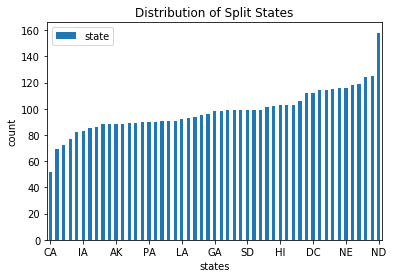

In [165]:
bar_state = pd.get_dummies(churn_df['state']).sum()

#KS                   1
#OH                   3
#OK                   3


bar_state.sort_values(ascending=True).plot.bar(label = 'state')
plt.title('Distribution of Split States')
plt.legend(loc = 'upper left')
plt.xticks(np.arange(0, 51, step=5), rotation = 0)
plt.ylabel('count')
plt.xlabel('states')

# Part 2: Feature Preprocessing

### Part 2.1: Get ground truth data and convert data types to numerical or boolean for next steps

In [220]:
churn_df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [0]:
# Get ground truth data
y = np.where(churn_df['churned'] == 'True',1,0)

# Drop some useless columns
to_drop = ['state','area_code','phone_number','churned']
churn_feat_space = churn_df.drop(to_drop, axis=1)

# yes and no have to be converted to boolean values
yes_no_cols = ["intl_plan","voice_mail_plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

X = churn_feat_space

In [222]:
# check the propotion of y = 1
print(y.sum() / y.shape * 100)

[14.14]


I removed the 'state' column in further analysis due to the time constraint but I wanted to understand how 'state' has an influence in our feature matrix. I vectorized 50 more columns for each and every state with one-hot-encoding but that would create too many features for now. Implementing different methods of encoding would be the next improvement

In [0]:
# for reference only
to_drop_state = ['area_code','phone_number','churned']
churn_feat_space_state = churn_df.drop(to_drop_state, axis=1)

# yes and no have to be converted to boolean values
yes_no_cols = ["intl_plan","voice_mail_plan"]
churn_feat_space_state[yes_no_cols] = churn_feat_space_state[yes_no_cols] == 'yes'

# sklearn.preprocessing.OneHotEncoder
churn_feat_space_state = pd.get_dummies(churn_feat_space_state, columns=['state'])

churn_feat_space_state.head()

#### (Feb 2020 Follow-up): Continue to look into the 'state' feature. To understand the geographical influence on feature importance, I bucketized states into 4 region intervals according to Census Bureau-designated regions and divisions: West, South, Midwest, and Northeast regions.

In [0]:
# Feb follow-up
# drop features
to_drop_state = ['area_code','phone_number','churned']
churn_feat_space_state_bin = churn_df.drop(to_drop_state, axis=1)

# yes and no have to be converted to boolean values
yes_no_cols = ["intl_plan","voice_mail_plan"]
churn_feat_space_state_bin[yes_no_cols] = churn_feat_space_state_bin[yes_no_cols] == 'yes'

def label_states (row):
    if row['state'] in ['WA', 'OR', 'ID', 'MT', 'WY', 'NV', 'CA', 'UT', 'CO', 'AZ', 'NM', 'AK', 'HI']:
      return 'West'
    if row['state'] in ['OK', 'AR', 'TX', 'LA', 'KY', 'TN', 'MS', 'AL', 'GA' 'FL', 'SC', 'NC', 'VA', 'WV', 'DC', 'DE', 'MD']:
      return 'South'
    if row['state'] in ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH']:
      return 'Midwest'
    if row['state'] in ['PA', 'NY', 'NJ', 'CT', 'RI', 'MA', 'VT', 'NH', 'ME']:
      return 'Northeast'

churn_feat_space_state_bin['state'] = churn_feat_space_state_bin.apply(lambda row: label_states(row), axis=1)

In [193]:
# Feb follow-up
churn_feat_space_state_bin.head()

,state,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,Midwest,128,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,Midwest,107,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,Northeast,137,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,Midwest,84,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,South,75,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [0]:
# Feb follow-up
d_state = pd.get_dummies(churn_feat_space_state_bin['state'])

In [0]:
# Feb follow-up
temp = churn_feat_space_state_bin.drop(columns = ['state'], axis = 1)
churn_with_state = pd.concat([temp, d_state], axis = 1)

In [196]:
# Feb follow-up
churn_with_state.head()

,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,Midwest,Northeast,South,West
0,128,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,1,0,0,0
1,107,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,1,0,0,0
2,137,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,1,0,0
3,84,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1,0,0,0
4,75,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0,1,0


In [0]:
# Feb follow-up
X_update = churn_with_state

### Part 2.2: Split dataset into training and testing

In [223]:
# Split the data into training and testing
from sklearn import model_selection

# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 4000 observation with 17 features
test data has 1000 observation with 17 features


In [198]:
# Feb follow-up
# Split the data into training and testing
from sklearn import model_selection

# Reserve 20% for testing
X_up_train, X_up_test, y_train, y_test = model_selection.train_test_split(X_update, y, test_size=0.2)

print('training data has ' + str(X_up_train.shape[0]) + ' observation with ' + str(X_up_train.shape[1]) + ' features')
print('test data has ' + str(X_up_test.shape[0]) + ' observation with ' + str(X_up_test.shape[1]) + ' features')

training data has 4000 observation with 21 features
test data has 1000 observation with 21 features


### Part 2.3: Feature Scaling

#### Part 2.3.1: Standardization

In [0]:
# Scale the data using standardization

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

In [225]:
X_train_std

array([[ 0.26571413, -0.31926223, -0.6008387 , ..., -0.17048312,
         0.37334549, -0.4365837 ],
       [ 0.08935659, -0.31926223, -0.6008387 , ...,  1.46680979,
         0.11917559,  1.09461735],
       [-0.89320685, -0.31926223, -0.6008387 , ...,  0.64816333,
         0.88168529,  0.32901682],
       ...,
       [ 0.31610199, -0.31926223, -0.6008387 , ...,  0.2388401 ,
         0.5873833 ,  0.32901682],
       [ 3.06224082, -0.31926223,  1.66434019, ...,  0.2388401 ,
        -1.94093836,  1.86021787],
       [-0.08700095,  3.13222139, -0.6008387 , ..., -0.98912958,
        -1.07140975, -1.20218422]])

####Part 2.3.2: Normalization

In [0]:
# Scale the data using normalization

from sklearn.preprocessing import MinMaxScaler
nor_scaler = MinMaxScaler()
X_train_nor = nor_scaler.fit_transform(X_train)
X_test_nor = nor_scaler.transform(X_test)

In [0]:
X_train_nor

array([[0.18565401, 0.        , 0.        , ..., 0.15      , 0.45      ,
        0.22222222],
       [0.4978903 , 0.        , 1.        , ..., 0.15      , 0.53518519,
        0.11111111],
       [0.55274262, 0.        , 1.        , ..., 0.2       , 0.45555556,
        0.11111111],
       ...,
       [0.57805907, 0.        , 0.        , ..., 0.4       , 0.60555556,
        0.        ],
       [0.17299578, 0.        , 0.        , ..., 0.45      , 0.62037037,
        0.22222222],
       [0.25738397, 0.        , 0.        , ..., 0.2       , 0.42592593,
        0.44444444]])

In [0]:
# Feb follow-up
# Scale the data using normalization

from sklearn.preprocessing import MinMaxScaler
nor_scaler = MinMaxScaler()
X_up_train_nor = nor_scaler.fit_transform(X_up_train)
X_up_test_nor = nor_scaler.transform(X_up_test)

# Part 3: Model Training and Result Evaluation

### Part 3.1: Model Training and Selection

In [0]:
#build models for classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

Group 1: Standardized data sets

In [259]:
# Train the model
classifier_logistic.fit(X_train_std, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [260]:
classifier_RF.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [261]:
classifier_KNN.fit(X_train_std, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [262]:
# Use 5-fold Cross Validation to select model based on accuracy 
# note: the machine either correctly classify or doesn't so we use classification score, not mean squared error
model_names = ['Logistic Regression','KNN','Random Forest']
model_list = [classifier_logistic, classifier_KNN, classifier_RF]
count = 0

for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train_std, y_train, cv=5, scoring = 'accuracy')
    print(cv_score)
    print('Model accuracy of ' + model_names[count] + ' is ' + str(cv_score.mean()))
    count += 1

[0.88375 0.86125 0.86375 0.8625  0.87   ]
Model accuracy of Logistic Regression is 0.8682500000000001
[0.91   0.8975 0.8975 0.8925 0.9   ]
Model accuracy of KNN is 0.8995000000000001
[0.96625 0.9575  0.95625 0.9625  0.97   ]
Model accuracy of Random Forest is 0.9625


Group 2: Normalized data sets

In [0]:
model_name = ['Logistic Regression', 'KNN', 'Random Forest']
model_list = [classifier_logistic, classifier_KNN, classifier_RF]
count = 0

for classifier in model_list:
  cv_score = model_selection.cross_val_score(classifier, X_train_nor, y_train, cv = 5, scoring = 'accuracy')
  print(cv_score)
  print('Model accuracy of ', model_name[count], ' is ', str(cv_score.mean()))
  count += 1

[0.8675  0.87875 0.87    0.8675  0.8475 ]
Model accuracy of  Logistic Regression  is  0.86625
[0.89875 0.8975  0.89375 0.9     0.89125]
Model accuracy of  KNN  is  0.89625
[0.95625 0.94875 0.96125 0.96375 0.95125]
Model accuracy of  Random Forest  is  0.95625


Based on cross validation performance results (accuracy), the Random Forest model has the highest accuracy among the 3 models.

We can also see that difference between scaling methods is small. Standardized date will be used in the following steps.

### Part 3.2: Use Grid Search to Find Optimal Hyperparameters

Feb follow-up: Logistic regression has lowest accuracy during the model selection step and lowest recall rate in the model evaluation step. I'd like to try to optimize the result with penalized logistic regression models.

In [0]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(model):
    print ("Best score: " + str(model.best_score_))
    print ("Best parameters set:")
    best_parameters = model.best_params_
    for param_name in sorted(parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [256]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

# ('l1', 1) ('l1', 5) ('l1', 10) ('l2', 1) ('l2', 5) ('l2', 10)
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(0.001, 0.01, 0.1, 1, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(), parameters, cv=5)
Grid_LR.fit(X_train_std, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': (0.001, 0.01, 0.1, 1, 5, 10),
                         'penalty': ('l1', 'l2')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [257]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.8695
Best parameters set:
C:0.01
penalty:l2


In [0]:
# best model
classifier_Grid_LR = Grid_LR.best_estimator_

### Add Polynomial features to Penalized Logistic Regression

In [0]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train_std)
X_test_poly = poly.transform(X_test_std)

In [269]:
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(0.001, 0.01, 0.1, 1, 5, 10)
}
Grid_LR_poly = GridSearchCV(LogisticRegression(), parameters, cv=5)
Grid_LR_poly.fit(X_train_poly, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': (0.001, 0.01, 0.1, 1, 5, 10),
                         'penalty': ('l1', 'l2')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [270]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR_poly)

Best score: 0.9174999999999999
Best parameters set:
C:1
penalty:l2


In [0]:
# best model
classifier_Grid_LR_poly = Grid_LR_poly.best_estimator_

###Part 3.3: Model Evaluation - Confusion Matrix (Precision, Recall, Accuracy)

Model evaluation from business stand point. Here th class of interest is positive (churned)

TP: correctly labeled real churn

Precision(PPV, positive predictive value): tp / (tp + fp);
Total number of true predictive churn divided by the total number of predictive churn;
High Precision means low fp, not many return users were predicted as churn users. 


Recall(sensitivity, hit rate, true positive rate): tp / (tp + fn)
Predict most postive or churn user correctly. High recall means low fn, not many churn users were predicted as return users.

In [0]:
from sklearn.metrics import confusion_matrix

# calculate accuracy, precision and recall, [[tn, fp],[fn, tp]]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: " + str(accuracy))
    print ("precision is: " + str(precision))
    print ("recall is: " + str(recall))

# print out confusion matrices
def draw_confusion_matrices(confusion_matrices):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for ' + classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Random Forest
Accuracy is: 0.958
precision is: 0.9537037037037037
recall is: 0.7357142857142858


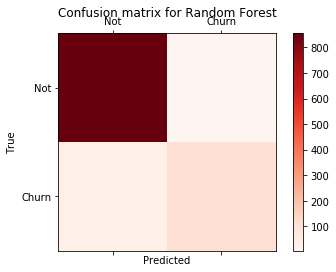

Logistic Regression
Accuracy is: 0.862
precision is: 0.5185185185185185
recall is: 0.2


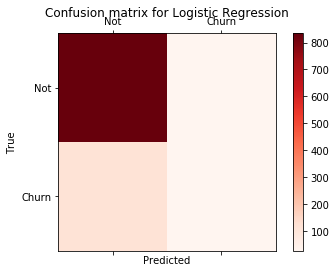

KNN
Accuracy is: 0.908
precision is: 0.8636363636363636
recall is: 0.40714285714285714


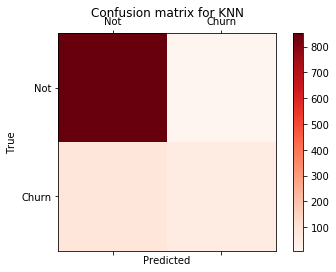

In [191]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest, logistic regression and KNN
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test, classifier_RF.predict(X_test_std))),
    ("Logistic Regression", confusion_matrix(y_test, classifier_logistic.predict(X_test_std))),
    ("KNN", confusion_matrix(y_test, classifier_KNN.predict(X_test_std)))
]

draw_confusion_matrices(confusion_matrices)

There are 14% churned users so the data is a little bit imbalanced. However, the Random Forest model does a good job in terms of recall metric (0.78), which is better than Logistic Regression (0.24) and KNN (0.37).

Penalized Logistic Regression (L2)
Accuracy is: 0.851
precision is: 0.5945945945945946
recall is: 0.14102564102564102


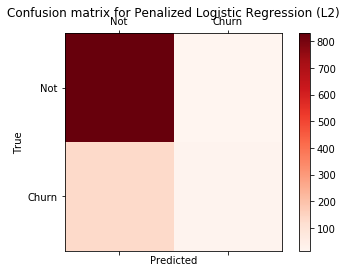

In [249]:
# Feb follow up

%matplotlib inline

# Confusion matrix, accuracy, precison and recall for penalized logistic regression
confusion_matrices_up = [
    ("Penalized Logistic Regression (L2)", confusion_matrix(y_test, classifier_Grid_LR.predict(X_test_std))),
]

draw_confusion_matrices(confusion_matrices_up)

In the attempt to improve the logistic regression model in terms of accuracy, precision, and recall metric, I added regularization into the regression model. However, only precision improved from 0.51 to 0.59. Accuracy and recall decreased. 

Penalized Logistic Regression (L2) with Polynomial Features
Accuracy is: 0.911
precision is: 0.8316831683168316
recall is: 0.5384615384615384


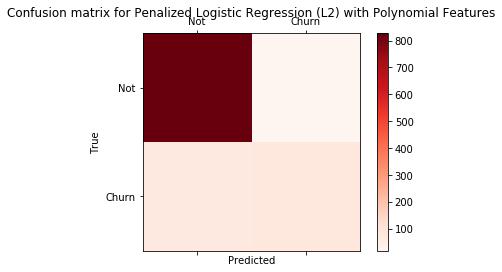

In [275]:
# (Feb follow up continued)
# Confusion matrix, accuracy, precison and recall for penalized logistic regression with polynomial features
confusion_matrices_poly = [
    ("Penalized Logistic Regression (L2) with Polynomial Features", confusion_matrix(y_test, classifier_Grid_LR_poly.predict(X_test_poly))),
]

draw_confusion_matrices(confusion_matrices_poly)

To further optimize the Logistic Regression model beyond adding regularization, I added polynomial features to the dataset. The number of features increased from 17 to 171. Accuracy is now 0.91, which is higher than that of the LR model and penalized LR model. Precision and recall has improved significantly. Precision has increased from 0.51/0.59 to 0.83 and Recall has increased from 0.2/0.14 to 0.53.
Although the logistic model is improved, it still cannot beat the Random Forest model. Therefore, the RF is still the best model for predicting the user churn classification.

### Part 3.4: Model Evaluation - ROC & AUC

We also evaluate the 3 models from the machine stand point, regardless of the cutoff. RandomForestClassifier, KNeighborsClassifier and LogisticRegression have predict_prob() function.

#### Part 3.4.1: ROC of RF Model

In [0]:
from sklearn.metrics import roc_curve

# Use predict_proba to get the probability results with Random Forest
y_pred_proba_rf = classifier_RF.predict_proba(X_test_std)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
#roc_curve returns 3 outputs: fpr, tpr, and threshold. We use a placeholder _ for threshold here.

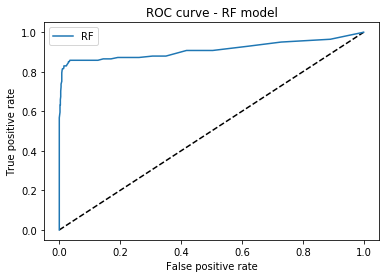

In [0]:
# draw ROC curve of Random Forest
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [0]:
from sklearn import metrics

# AUC score
metrics.auc(fpr_rf,tpr_rf)

0.911277338815545

#### Part 3.4.2: ROC of LR Model

In [0]:
# Use predict_proba to get the probability results of Logistic Regression
y_pred_proba_lr = classifier_logistic.predict_proba(X_test_std)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)

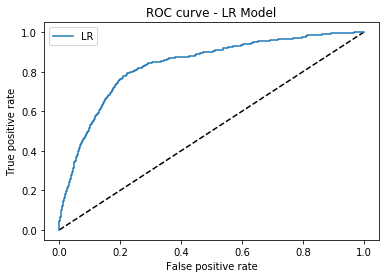

In [0]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [0]:
# AUC score
metrics.auc(fpr_lr, tpr_lr)

0.8340287624688472

#### Part 3.4.3: ROC of Penalized LR Model

In [0]:
from sklearn.metrics import roc_curve
# Use predict_proba to get the probability results of Penalized Logistic Regression
y_pred_proba_lrp = classifier_Grid_LR.predict_proba(X_test_std)[:, 1]
fpr_lrp, tpr_lrp, _ = roc_curve(y_test, y_pred_proba_lrp)

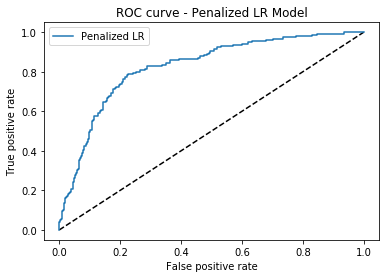

In [253]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lrp, tpr_lrp, label='Penalized LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Penalized LR Model')
plt.legend(loc='best')
plt.show()

In [255]:
from sklearn import metrics
# AUC score
metrics.auc(fpr_lrp, tpr_lrp)

0.8251078502855755

#### Part 3.4.34: ROC of Penalized LR Model with Polynomial Features

In [0]:
# Use predict_proba to get the probability results of Penalized Logistic Regression with Polynimial features
y_pred_proba_lrpp = classifier_Grid_LR_poly.predict_proba(X_test_poly)[:, 1]
fpr_lrpp, tpr_lrpp, _ = roc_curve(y_test, y_pred_proba_lrpp)

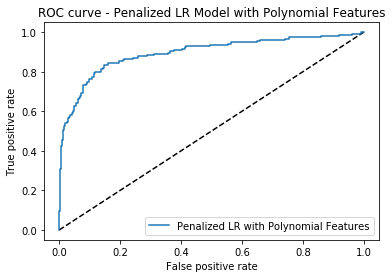

In [278]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lrpp, tpr_lrpp, label='Penalized LR with Polynomial Features')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Penalized LR Model with Polynomial Features')
plt.legend(loc='best')
plt.show()

In [279]:
# AUC score
metrics.auc(fpr_lrpp, tpr_lrpp)

0.8945649532142425

#### Part 3.4.5: ROC of KNN Model

In [0]:
# Use predict_proba to get the probability results of KNN
y_pred_proba_knn = classifier_KNN.predict_proba(X_test_std)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)

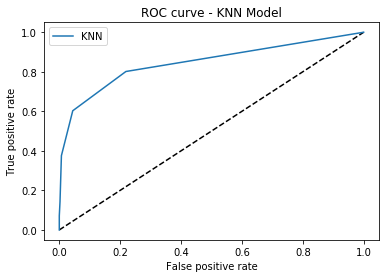

In [0]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_knn, tpr_knn, label = 'KNN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - KNN Model')
plt.legend(loc = 'best')
plt.show()

In [0]:
# AUC score
metrics.auc(fpr_knn, tpr_knn)

0.8458705900808297

In terms of ROC and AUC, the Random Forest model outstands the other 2 models, followed by KNN then Logistic Regression model.

# Part 4: Feature Selection

### Part 4.1:  Logistic Regression Model - Feature Selection Discussion 

The correlated features that we are interested in: (total_day_minutes, total_day_charge), (total_eve_minutes, total_eve_charge), (total_intl_minutes, total_intl_charge).

Part 4.1.1: Add L1 regularization to logistic regression and check the coef for feature selection

In [0]:
scaler = StandardScaler()
X_std_l1 = scaler.fit_transform(X)
LRmodel_l1 = LogisticRegression(penalty='l1', C = 0.1, solver = 'saga')
LRmodel_l1.fit(X_std_l1, y)
LRmodel_l1.coef_[0]

print ("Logistic Regression (L1) Coefficients")
for coef, col_name in sorted(zip(map(lambda x: round(x, 4), LRmodel_l1.coef_[0]), \
                      churn_feat_space.columns), key = lambda pair:(abs(pair[0])), reverse = True):
    print (col_name, ": \t", str(coef))

Logistic Regression (L1) Coefficients
number_customer_service_calls : 	 0.6468
intl_plan : 	 0.5929
voice_mail_plan : 	 -0.4415
total_day_minutes : 	 0.3662
total_day_charge : 	 0.3366
total_eve_charge : 	 0.169
total_eve_minutes : 	 0.1599
total_intl_calls : 	 -0.1494
total_intl_charge : 	 0.119
total_night_minutes : 	 0.0999
total_intl_minutes : 	 0.0985
total_night_charge : 	 0.0765
account_length : 	 0.0356
total_day_calls : 	 0.0307
total_night_calls : 	 -0.0111
total_eve_calls : 	 -0.0091
number_vmail_messages : 	 0.0


Part 4.1.2: Add L2 regularization to logistic regression and check the coef for feature selection

In [0]:
scaler = StandardScaler()
X_std_l2 = scaler.fit_transform(X)
LRmodel_l2 = LogisticRegression(penalty="l2", C = 0.1)
LRmodel_l2.fit(X_std_l2, y)
LRmodel_l2.coef_[0]
print ("Logistic Regression (L2) Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l2.coef_[0]), \
                      churn_feat_space.columns), key=lambda k_v:(-abs(k_v[0]))):
    print (v + ": \t" + str(k))

Logistic Regression (L2) Coefficients
number_customer_service_calls: 	0.6604
voice_mail_plan: 	-0.6199
intl_plan: 	0.6039
total_day_minutes: 	0.3626
total_day_charge: 	0.3621
total_eve_charge: 	0.1766
total_eve_minutes: 	0.1764
total_intl_calls: 	-0.1715
number_vmail_messages: 	0.1659
total_intl_charge: 	0.1204
total_intl_minutes: 	0.12
total_night_minutes: 	0.0997
total_night_charge: 	0.0992
account_length: 	0.0548
total_day_calls: 	0.0501
total_night_calls: 	-0.0313
total_eve_calls: 	-0.0296



### Part 4.2:  Random Forest Model - Feature Importance Discussion

In [0]:
# check feature importance of random forest for feature selection

forest = RandomForestClassifier()
forest.fit(X, y)

importances = forest.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for importance, col_name in sorted(zip(map(lambda x: round(x, 4), importances), churn_feat_space.columns), reverse=True):
    print (col_name + ": \t" + str(importance))

Feature importance ranking by Random Forest Model:
total_day_minutes: 	0.1509
total_day_charge: 	0.1401
number_customer_service_calls: 	0.1131
intl_plan: 	0.0922
total_eve_charge: 	0.0692
total_eve_minutes: 	0.0606
total_intl_calls: 	0.0563
total_intl_minutes: 	0.042
total_night_minutes: 	0.041
total_night_charge: 	0.0384
total_intl_charge: 	0.0375
account_length: 	0.0292
total_day_calls: 	0.0276
number_vmail_messages: 	0.0273
total_night_calls: 	0.026
voice_mail_plan: 	0.0243
total_eve_calls: 	0.0241


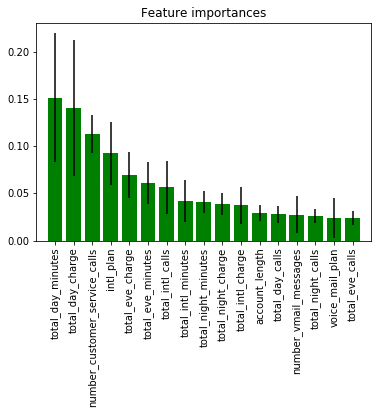

In [0]:
# Plot the feature importances of the forest
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), ['total_day_minutes', 'total_day_charge', 'number_customer_service_calls', 'intl_plan', \
                               'total_eve_charge', 'total_eve_minutes', 'total_intl_calls', 'total_intl_minutes', 'total_night_minutes', \
                               'total_night_charge', 'total_intl_charge', 'account_length', 'total_day_calls', 'number_vmail_messages',  \
                               'total_night_calls', 'voice_mail_plan', 'total_eve_calls'], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

Feature imporance summay:

Among the correlated features that we are interested in: (total_day_minutes, total_day_charge), (total_eve_minutes, total_eve_charge), (total_intl_minutes, total_intl_charge), the (total_day_minutes, total_day_charge), (total_eve_minutes, total_eve_charge) have higher coefficient/imporance.

In addition, we can see that number_customer_service_calls and intl_plan are also importance features



In [113]:
# Feb follow-up
# check feature importance of random forest for feature selection

forest2 = RandomForestClassifier()
forest2.fit(X_update, y)

importances2 = forest2.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for importance, col_name in sorted(zip(map(lambda x: round(x, 4), importances2), X_update.columns), reverse=True):
    print (col_name + ": \t" + str(importance))

Feature importance ranking by Random Forest Model:
total_day_minutes: 	0.156
total_day_charge: 	0.13
number_customer_service_calls: 	0.1154
intl_plan: 	0.0805
total_eve_minutes: 	0.065
total_eve_charge: 	0.0637
total_intl_calls: 	0.0526
total_night_charge: 	0.0399
total_intl_minutes: 	0.0396
total_intl_charge: 	0.0388
total_night_minutes: 	0.0386
account_length: 	0.0298
number_vmail_messages: 	0.0297
total_day_calls: 	0.0289
total_night_calls: 	0.0274
total_eve_calls: 	0.0263
voice_mail_plan: 	0.0211
West: 	0.0044
South: 	0.0044
Northeast: 	0.0039
Midwest: 	0.0039


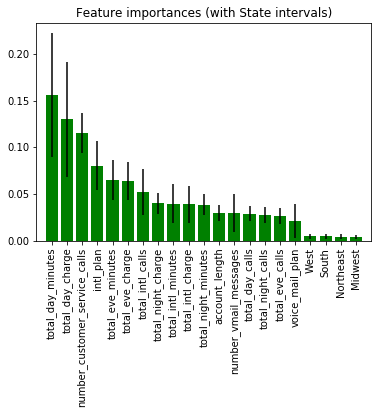

In [116]:
# Feb follow-up
# Plot the feature importances of the forest
indices = np.argsort(importances2)[::-1]
std = np.std([tree.feature_importances_ for tree in forest2.estimators_],
             axis=0)

plt.figure()
plt.title("Feature importances (with State intervals)")
plt.bar(range(X_update.shape[1]), importances2[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_update.shape[1]), ['total_day_minutes', 'total_day_charge', 'number_customer_service_calls', 'intl_plan', \
                               'total_eve_minutes', 'total_eve_charge', 'total_intl_calls', 'total_night_charge', \
                               'total_intl_minutes', 'total_intl_charge', 'total_night_minutes', 'account_length', 'number_vmail_messages', 'total_day_calls',  \
                               'total_night_calls', 'total_eve_calls', 'voice_mail_plan', 'West', 'South', 'Northeast', 'Midwest'], rotation=90)
plt.xlim([-1, X_update.shape[1]])
plt.show()

Feb follow-up update: The influence on geographical features (state) is not significant.